In [1]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('/home/luca/GitRepositories/Brancher')

import chainer
import chainer.functions as F
import matplotlib.pyplot as plt
import numpy as np

from brancher.distributions import NormalDistribution, LogNormalDistribution
from brancher.variables import DeterministicVariable, RandomVariable, ProbabilisticModel
from brancher.standard_variables import NormalVariable, LogNormalVariable
from brancher import inference
import brancher.functions as BF

In [2]:
# Real model
mu_real = 1.
nu_real = 1.

# Probabilistic model
mu = NormalVariable(0., 2., "mu")
nu = LogNormalVariable(0., 1., "nu")
x = NormalVariable(BF.sin(mu), nu, "x") #TODO: Fix unary operator -
model = ProbabilisticModel([mu, nu, x]) 

model.model_summary

,mu_var,nu_mu,mu_mean,nu_sigma,x,mu,nu
Distribution,Deterministic,Deterministic,Deterministic,Deterministic,Normal,Normal,Log Normal
Parents,(),(),(),(),"{nu, mu}","{mu_var, mu_mean}","{nu_sigma, nu_mu}"
Observed,False,False,False,False,False,False,False


In [3]:
# Print samples
sample = model.get_sample(5)
sample

,mu_var,mu_mean,mu,nu_sigma,nu_mu,nu,x
0,1.854587,0.0,0.347604,0.541325,0.0,0.506969,-0.744915
1,1.854587,0.0,2.712392,0.541325,0.0,0.198692,-0.030138
2,1.854587,0.0,-1.070388,0.541325,0.0,2.704726,-0.301458
3,1.854587,0.0,-0.420039,0.541325,0.0,0.240410,-0.652323
4,1.854587,0.0,0.473910,0.541325,0.0,2.852729,0.925209


In [4]:
# Print samples from single variable
x_sample = x.get_sample(5)
x_sample

,x
0,1.440571
1,-1.673813
2,-0.525077
3,0.173008
4,-0.280993


In [5]:
# Print samples conditional on an input
in_sample = model.get_sample(5, input_values={mu: 100.})
in_sample

,mu,nu_sigma,nu_mu,nu,x
0,100.0,0.541325,0.0,0.554976,-0.846680
1,100.0,0.541325,0.0,0.540205,-1.306114
2,100.0,0.541325,0.0,2.403955,-3.448499
3,100.0,0.541325,0.0,0.270676,-1.331100
4,100.0,0.541325,0.0,1.108322,-0.784866


In [6]:
# # Generate data
data = model.get_sample(number_samples=10, input_values={mu: mu_real, nu: nu_real})

# Observe data
x.observe(data) #TODO: Implement observe method on probabilisticModel
model.model_summary

,mu_var,nu_mu,mu_mean,nu_sigma,x,mu,nu
Distribution,Deterministic,Deterministic,Deterministic,Deterministic,Normal,Normal,Log Normal
Parents,(),(),(),(),"{nu, mu}","{mu_var, mu_mean}","{nu_sigma, nu_mu}"
Observed,False,False,False,False,True,False,False


100%|██████████| 800/800 [00:13<00:00, 59.43it/s]


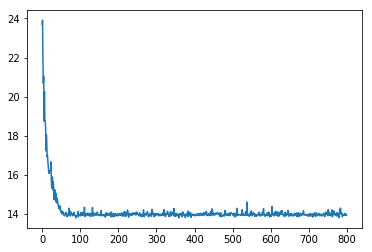

In [7]:
# Variational model
Qmu = NormalVariable(0., 1., "mu", learnable=True)
Qnu = LogNormalVariable(0., 1., "nu", learnable=True)
model.set_posterior_model(ProbabilisticModel([Qmu, Qnu]))

# Inference
inference.stochastic_variational_inference(model,
                                           number_iterations=800,
                                           number_samples=50,
                                           optimizer=chainer.optimizers.Adam(0.05))
loss_list = model.diagnostics["loss curve"]
plt.plot(loss_list)

In [8]:
# print posterior sample
post_sample = model.get_posterior_sample(1000)
post_sample.describe()

,mu,nu,x,mu_mean,mu_var,nu_sigma,nu_mu
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.349018,0.780682,0.908551,1.355214,-1.332098,-0.627701,-0.324789
std,0.464360,0.337424,0.847891,0.000000,0.000000,0.000000,0.000000
min,-0.369641,0.213782,-1.566112,1.355214,-1.332098,-0.627701,-0.324789
25%,1.035802,0.547389,0.365960,1.355214,-1.332098,-0.627701,-0.324789
50%,1.341336,0.722998,0.907593,1.355214,-1.332098,-0.627701,-0.324789
75%,1.669104,0.949723,1.459839,1.355214,-1.332098,-0.627701,-0.324789
max,2.691750,3.326164,4.270887,1.355214,-1.332098,-0.627701,-0.324789


(-5, 5)

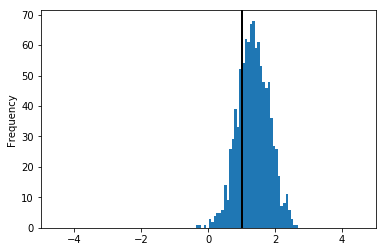

In [9]:
post_sample["mu"].plot.hist(stacked=False, bins=40)
plt.axvline(x=mu_real, c="k", lw=2)
plt.xlim(-5,5)

(0, 6)

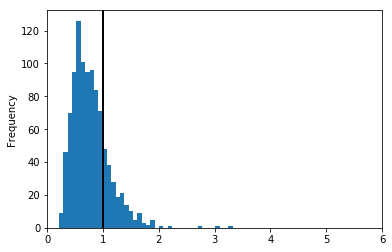

In [10]:
post_sample["nu"].plot.hist(stacked=False, bins=40)
plt.axvline(x=nu_real, c="k", lw=2)
plt.xlim(0,6)

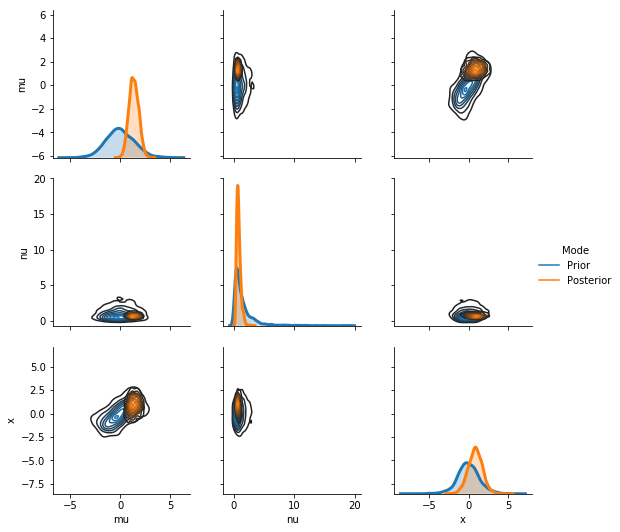

In [11]:
from brancher.visualizations import plot_posterior

plot_posterior(model, variables=["mu", "nu", "x"])